### ZSCORE

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Subset
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")




Using cuda device


In [2]:
file_path = r"C:\Users\valdi\OneDrive\Desktop\Phys 361\ML Project\Data\Testing\Simulated_Test_Data\noise_0_device_7_file_008.npy"


sample = np.load(file_path, allow_pickle=True).item()

sensor = sample['sensor']
label = sample['label']

sensor.shape

sensor = torch.tensor(sensor, dtype=torch.float32).view(-1)

sensor.view(-1).shape

torch.Size([900])

In [3]:
class DNN_Data(torch.utils.data.Dataset):
    """
    Dataset class for fully connected DNN training on quantum dot sensor data.
    """

    def __init__(self, data_file, label_map, num_points=150000, transform=None, target_transform=None, norm_method=None):
        self.data_files = data_file
        self.files = [f for f in os.listdir(data_file) if f.endswith('.npy')]
        if num_points < len(self.files):
            self.files = np.random.choice(self.files, size=num_points, replace=False)
        self.label_map = label_map
        self.transform = transform
        self.target_transform = target_transform
        self.norm_method = norm_method

        # Precomputed from training data
        self.mean = -0.02983519289686415
        self.std = 0.9185856299380564
        self.min = -1.5295182466506958
        self.max = 5.044922351837158

    def __len__(self):
        return len(self.files)
    
    def normalize(self, arr):
        if self.norm_method == "zscore":
            return (arr - self.mean) / self.std
        elif self.norm_method == "minmax":
            return (arr - self.min) / (self.max - self.min)
        elif self.norm_method == "unit":
            norm = np.linalg.norm(arr)
            return arr / norm if norm > 0 else arr
        else:
            return arr

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_files, self.files[idx])
        sample = np.load(file_path, allow_pickle=True).item()

        sensor = sample['sensor']  # shape (30, 30)
        labels = sample['label']  # shape (30, 30)

        sensor = sensor.flatten()
        sensor = self.normalize(sensor)
        sensor = torch.tensor(sensor, dtype=torch.float32)

        label = np.zeros(len(self.label_map))
        for i, key in enumerate(self.label_map.keys()):
            label[i] = np.sum(labels == key) / (labels.shape[0] ** 2)
        label = torch.tensor(label, dtype=torch.float32)

        return sensor, label


In [4]:

class DNNModel(nn.Module):
    def __init__(self, input_dim=900, output_dim=5): # 30x30 = 900 for the input, and 5 for the output based on the 5 dot classes.
        super(DNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return probs 
    


In [5]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    total_mse = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) 

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            correct, samples = calculate_accuracy(outputs, labels)
            total_correct += correct
            total_samples += samples

            probs = torch.nn.functional.softmax(outputs, dim=1)
            mse = torch.nn.functional.mse_loss(probs, labels)
            total_mse += mse.item() * samples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    mse_accuracy = total_mse / total_samples

    return avg_loss, accuracy, mse_accuracy

def calculate_accuracy(outputs, labels):
    """Accuracy as exact match between predicted and argmax of soft label."""
    preds = torch.argmax(outputs, dim=1)
    true = torch.argmax(labels, dim=1)

    correct = (preds == true).sum().item()
    total = labels.size(0)
    return correct, total


Epoch 1/100
Done with epoch 0
Epoch 2/100
Done with epoch 1
Epoch 3/100
Done with epoch 2
Epoch 4/100
Done with epoch 3
Epoch 5/100
Done with epoch 4
Epoch 6/100
Done with epoch 5
Epoch 7/100
Done with epoch 6
Epoch 8/100
Done with epoch 7
Epoch 9/100
Done with epoch 8
Epoch 10/100
Done with epoch 9
Epoch 11/100
Done with epoch 10
Epoch 12/100
Done with epoch 11
Epoch 13/100
Done with epoch 12
Epoch 14/100
Done with epoch 13
Epoch 15/100
Done with epoch 14
Epoch 16/100
Done with epoch 15
Epoch 17/100
Done with epoch 16
Epoch 18/100
Done with epoch 17
Epoch 19/100
Done with epoch 18
Epoch 20/100
Done with epoch 19
Epoch 21/100
Done with epoch 20
Epoch 22/100
Done with epoch 21
Epoch 23/100
Done with epoch 22
Epoch 24/100
Done with epoch 23
Epoch 25/100
Done with epoch 24
Epoch 26/100
Done with epoch 25
Epoch 27/100
Done with epoch 26
Epoch 28/100
Done with epoch 27
Epoch 29/100
Done with epoch 28
Epoch 30/100
Done with epoch 29
Epoch 31/100
Done with epoch 30
Epoch 32/100
Done with epoc

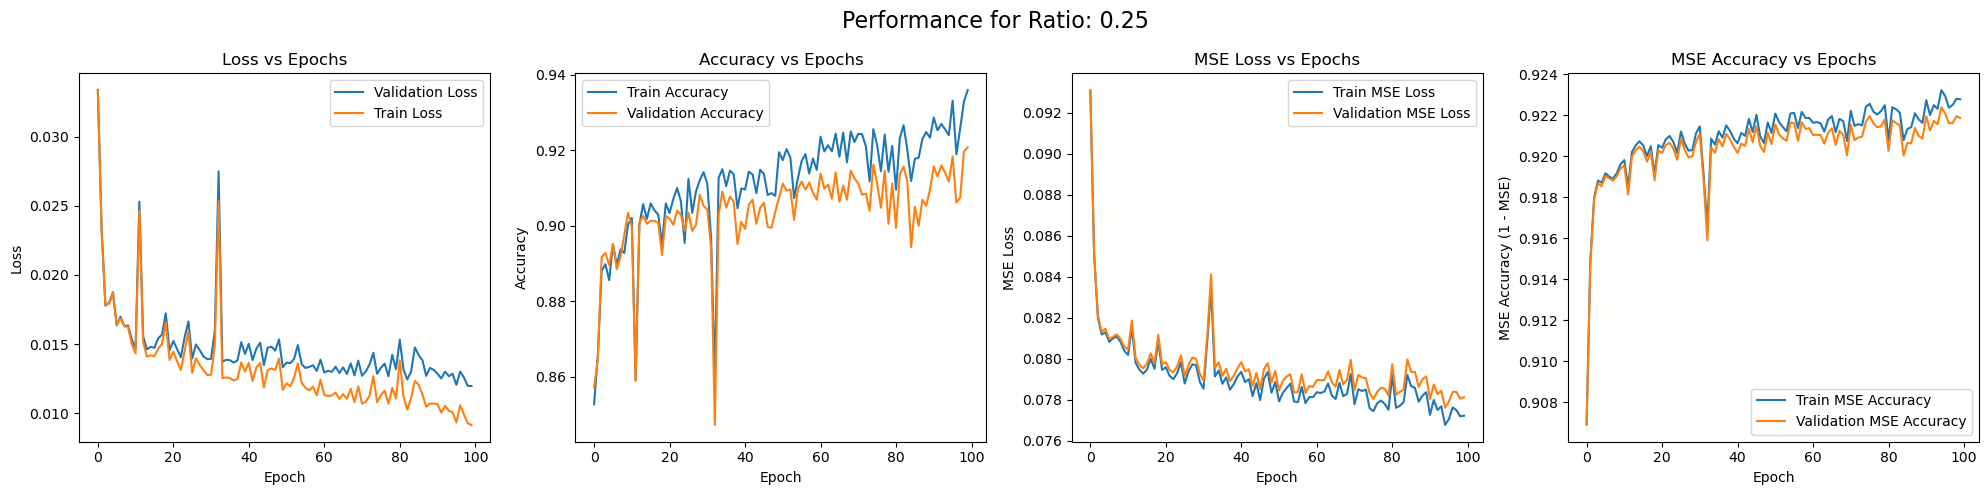

=== Ratio 0.25 ===
Test Accuracy:  0.925959595959596
Test MSE Loss:  0.07803449949080293
Test MSE Accuracy:  0.9219655005091971
Test Loss:  0.011072400858569326


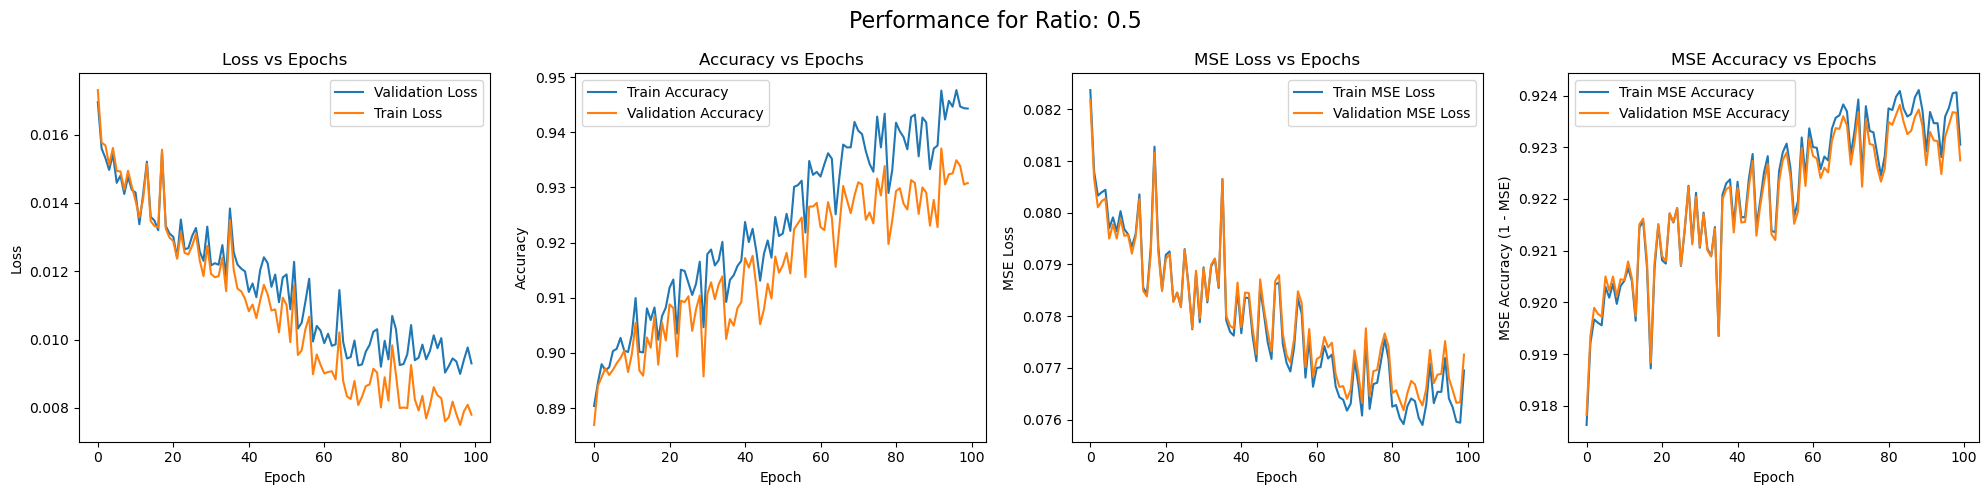

=== Ratio 0.5 ===
Test Accuracy:  0.9376767676767677
Test MSE Loss:  0.07765383171764287
Test MSE Accuracy:  0.9223461682823572
Test Loss:  0.009468547879915797


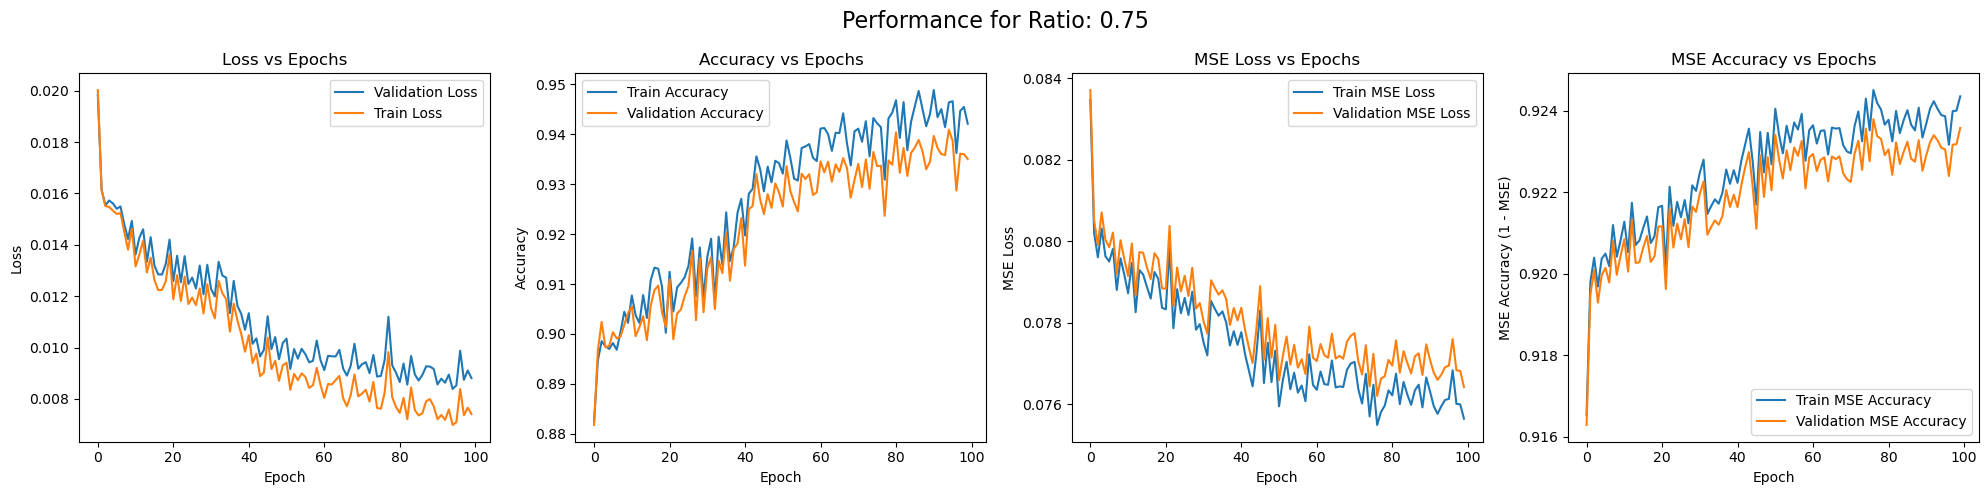

=== Ratio 0.75 ===
Test Accuracy:  0.941010101010101
Test MSE Loss:  0.07634388598980325
Test MSE Accuracy:  0.9236561140101968
Test Loss:  0.008852765676706578


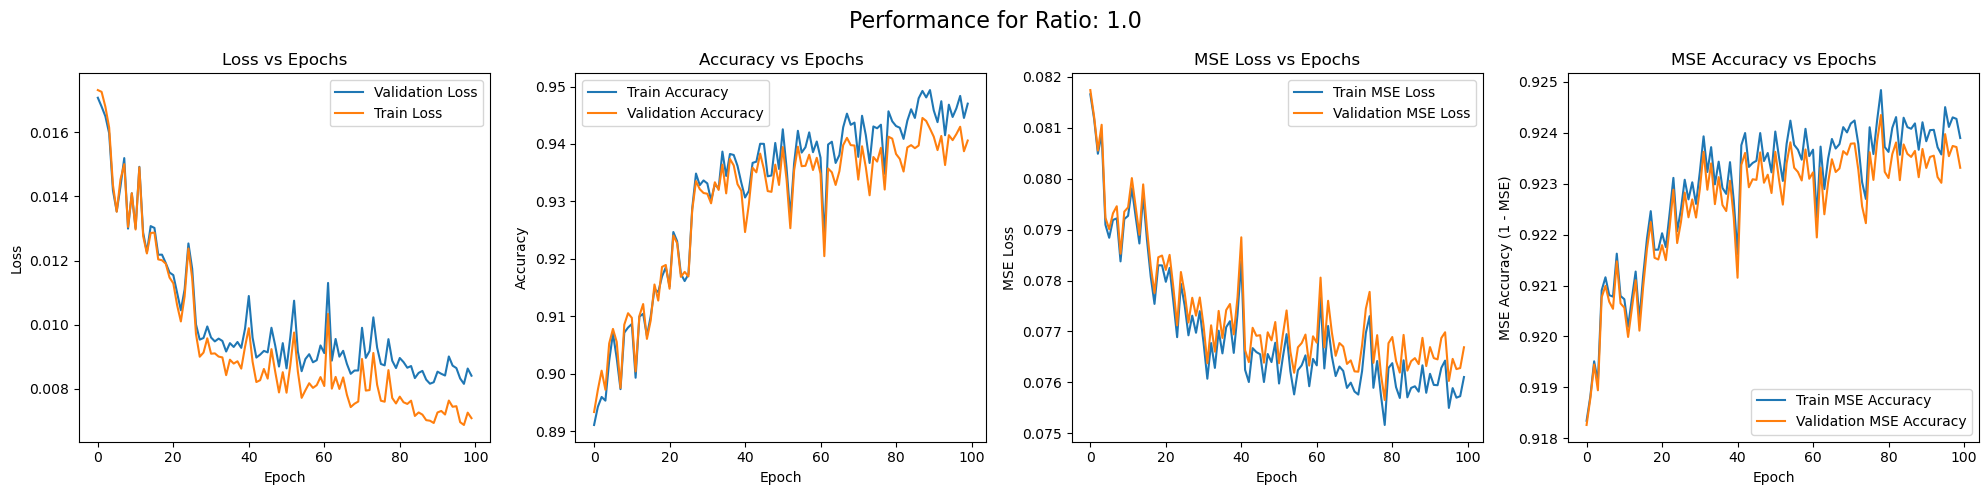

=== Ratio 1.0 ===
Test Accuracy:  0.942020202020202
Test MSE Loss:  0.07675595220291254
Test MSE Accuracy:  0.9232440477970875
Test Loss:  0.008563229616618517


In [6]:
label_map = {
    0: 'No Dot',
    0.5: 'Left Dot',
    1: 'Central Dot',
    1.5: 'Right Dot',
    2: 'Double Dot'
}

num_points = 150000
batch_size = 150

data_file_train = "Data\\Training\\Simulated_Train_Data\\Simulated_Train_Data"
data_file_test = "Data\\Testing\\Simulated_Test_Data"

train_dataset = DNN_Data(data_file_train, label_map, num_points=num_points, norm_method="minmax")
test_dataset = DNN_Data(data_file_test, label_map, num_points=num_points, norm_method="minmax")

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


dataset_size = len(train_dataset)
all_indices = np.arange(dataset_size)
np.random.seed(42)
np.random.shuffle(all_indices)
ratios = [0.25, 0.5, 0.75, 1.0]
results = {}

for ratio in ratios:
    subset_size = int(ratio * dataset_size)
    subset_indices = all_indices[:subset_size]
    train_size = int(0.9 * subset_size)
    train_indices = subset_indices[:train_size]
    val_indices = subset_indices[train_size:]

    train_split = Subset(train_dataset, train_indices)
    val_split = Subset(train_dataset, val_indices)

    train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False)
    num_epochs = 100

    model = DNNModel(input_dim=900, output_dim=5).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    performance_log = {
        'train_accuracy': [],
        'train_mse_accuracy': [],
        'val_accuracy': [],
        'val_mse_accuracy': [],
        'test_accuracy': [],
        'test_mse_accuracy': [],
        'train_loss': [],
        'val_loss': [],
        'test_loss': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_train_loss = 0.0
        print(f"Done with epoch {epoch}")

        for batch_inputs, batch_targets in train_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            optimizer.zero_grad()
            predictions = model(batch_inputs)
            loss = criterion(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_loss, train_acc, train_mse_acc = evaluate(model, train_loader, criterion)
        performance_log['train_loss'].append(train_loss)
        performance_log['train_accuracy'].append(train_acc)
        performance_log['train_mse_accuracy'].append(train_mse_acc)

        val_loss, val_acc, val_mse_acc = evaluate(model, val_loader, criterion)
        performance_log['val_loss'].append(val_loss)
        performance_log['val_accuracy'].append(val_acc)
        performance_log['val_mse_accuracy'].append(val_mse_acc)

    test_loss, test_acc, test_mse_acc = evaluate(model, test_dataloader, criterion)
    performance_log['test_loss'].append(test_loss)
    performance_log['test_accuracy'].append(test_acc)
    performance_log['test_mse_accuracy'].append(test_mse_acc)

    torch.save(model.state_dict(), f"DNN_model_ratio_{ratio}_epoch_{num_epochs}.pth")

    max_length = max(len(v) for v in performance_log.values())
    for key in performance_log:
        if len(performance_log[key]) < max_length:
            performance_log[key] += [np.nan] * (max_length - len(performance_log[key]))

    metrics_df = pd.DataFrame(performance_log)
    metrics_df.to_csv(f"DNN_metrics_ratio_{ratio}_epoch_{num_epochs}.csv", index=False)


    results[ratio] = performance_log

    print("Training is done")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test MSE Accuracy: {test_mse_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

for ratio in results:
    performance_log = results[ratio]

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Performance for Ratio: {ratio}', fontsize=16)

    # Loss plot
    ax[0].plot(performance_log['val_loss'], label="Validation Loss")
    ax[0].plot(performance_log['train_loss'], label="Train Loss")
    ax[0].set_title("Loss vs Epochs")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    # Accuracy plot
    ax[1].plot(performance_log['train_accuracy'], label="Train Accuracy")
    ax[1].plot(performance_log['val_accuracy'], label="Validation Accuracy")
    ax[1].set_title("Accuracy vs Epochs")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    # MSE Loss plot
    ax[2].plot(performance_log['train_mse_accuracy'], label="Train MSE Loss")
    ax[2].plot(performance_log['val_mse_accuracy'], label="Validation MSE Loss")
    ax[2].set_title("MSE Loss vs Epochs")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("MSE Loss")
    ax[2].legend()

    # MSE Accuracy plot
    train_mse_acc = [1 - v for v in performance_log['train_mse_accuracy']]
    val_mse_acc = [1 - v for v in performance_log['val_mse_accuracy']]
    ax[3].plot(train_mse_acc, label="Train MSE Accuracy")
    ax[3].plot(val_mse_acc, label="Validation MSE Accuracy")
    ax[3].set_title("MSE Accuracy vs Epochs")
    ax[3].set_xlabel("Epoch")
    ax[3].set_ylabel("MSE Accuracy (1 - MSE)")
    ax[3].legend()

    plt.tight_layout()
    plt.show()

    print(f"=== Ratio {ratio} ===")
    print("Test Accuracy: ", performance_log['test_accuracy'][0])
    print("Test MSE Loss: ", performance_log['test_mse_accuracy'][0])
    print("Test MSE Accuracy: ", 1 - performance_log['test_mse_accuracy'][0])
    print("Test Loss: ", performance_log['test_loss'][0])


### ZSCORE

Epoch 1/100
Done with epoch 0
Epoch 2/100
Done with epoch 1
Epoch 3/100
Done with epoch 2
Epoch 4/100
Done with epoch 3
Epoch 5/100
Done with epoch 4
Epoch 6/100
Done with epoch 5
Epoch 7/100
Done with epoch 6
Epoch 8/100
Done with epoch 7
Epoch 9/100
Done with epoch 8
Epoch 10/100
Done with epoch 9
Epoch 11/100
Done with epoch 10
Epoch 12/100
Done with epoch 11
Epoch 13/100
Done with epoch 12
Epoch 14/100
Done with epoch 13
Epoch 15/100
Done with epoch 14
Epoch 16/100
Done with epoch 15
Epoch 17/100
Done with epoch 16
Epoch 18/100
Done with epoch 17
Epoch 19/100
Done with epoch 18
Epoch 20/100
Done with epoch 19
Epoch 21/100
Done with epoch 20
Epoch 22/100
Done with epoch 21
Epoch 23/100
Done with epoch 22
Epoch 24/100
Done with epoch 23
Epoch 25/100
Done with epoch 24
Epoch 26/100
Done with epoch 25
Epoch 27/100
Done with epoch 26
Epoch 28/100
Done with epoch 27
Epoch 29/100
Done with epoch 28
Epoch 30/100
Done with epoch 29
Epoch 31/100
Done with epoch 30
Epoch 32/100
Done with epoc

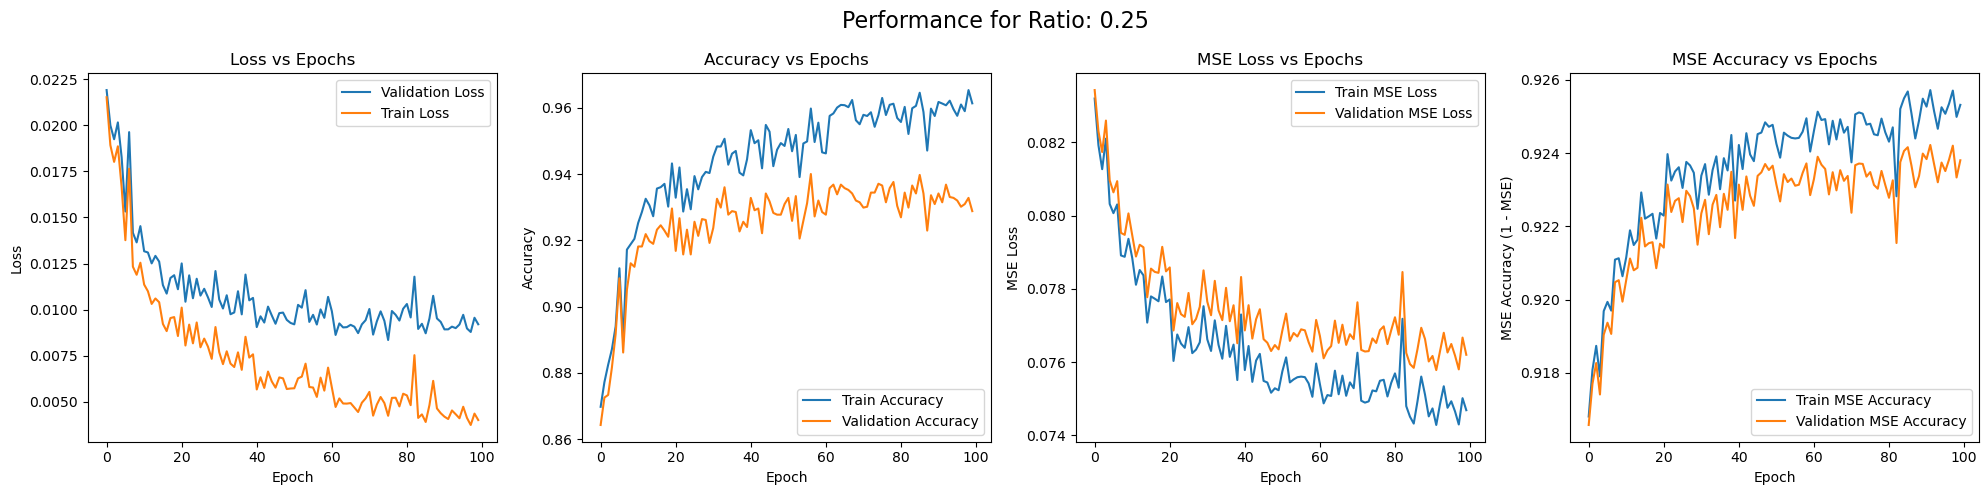

=== Ratio 0.25 ===
Test Accuracy:  0.9313131313131313
Test MSE Loss:  0.07635796770001903
Test MSE Accuracy:  0.923642032299981
Test Loss:  0.009155513464727184


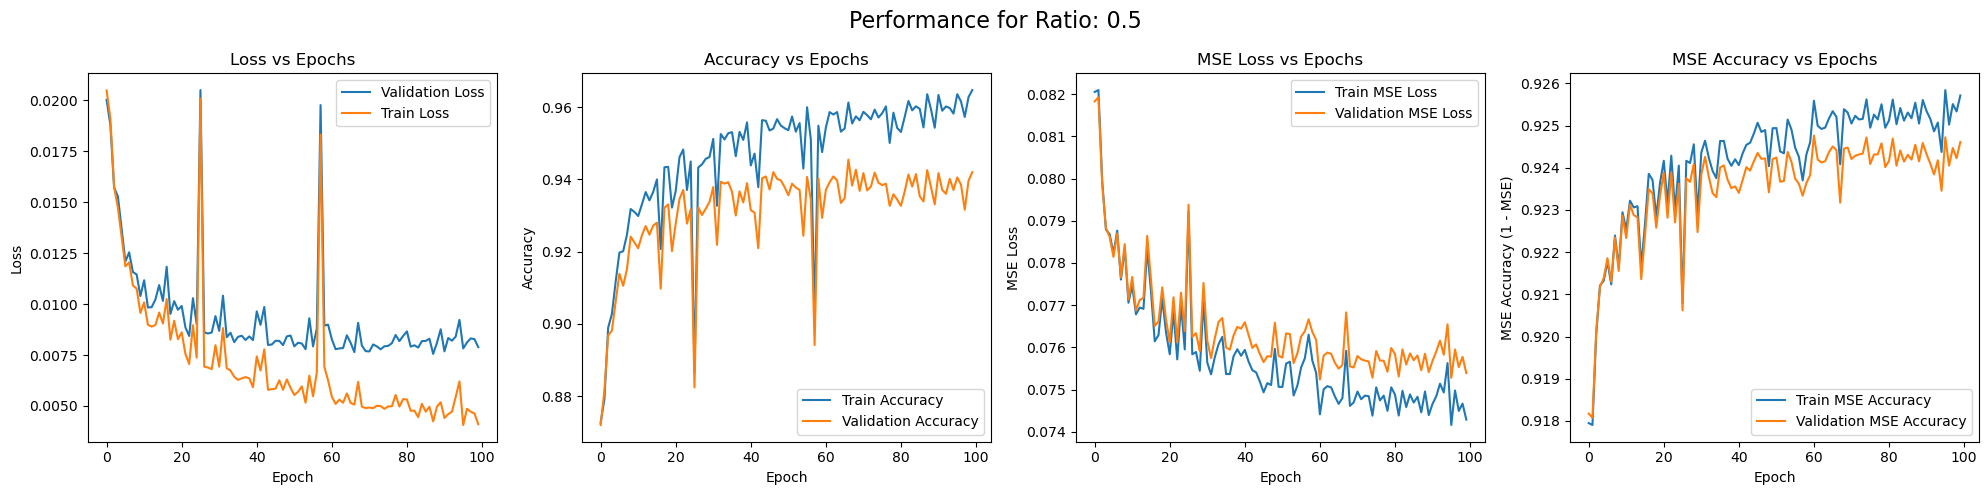

=== Ratio 0.5 ===
Test Accuracy:  0.9406060606060606
Test MSE Loss:  0.0757964989452651
Test MSE Accuracy:  0.9242035010547349
Test Loss:  0.008430825987350985


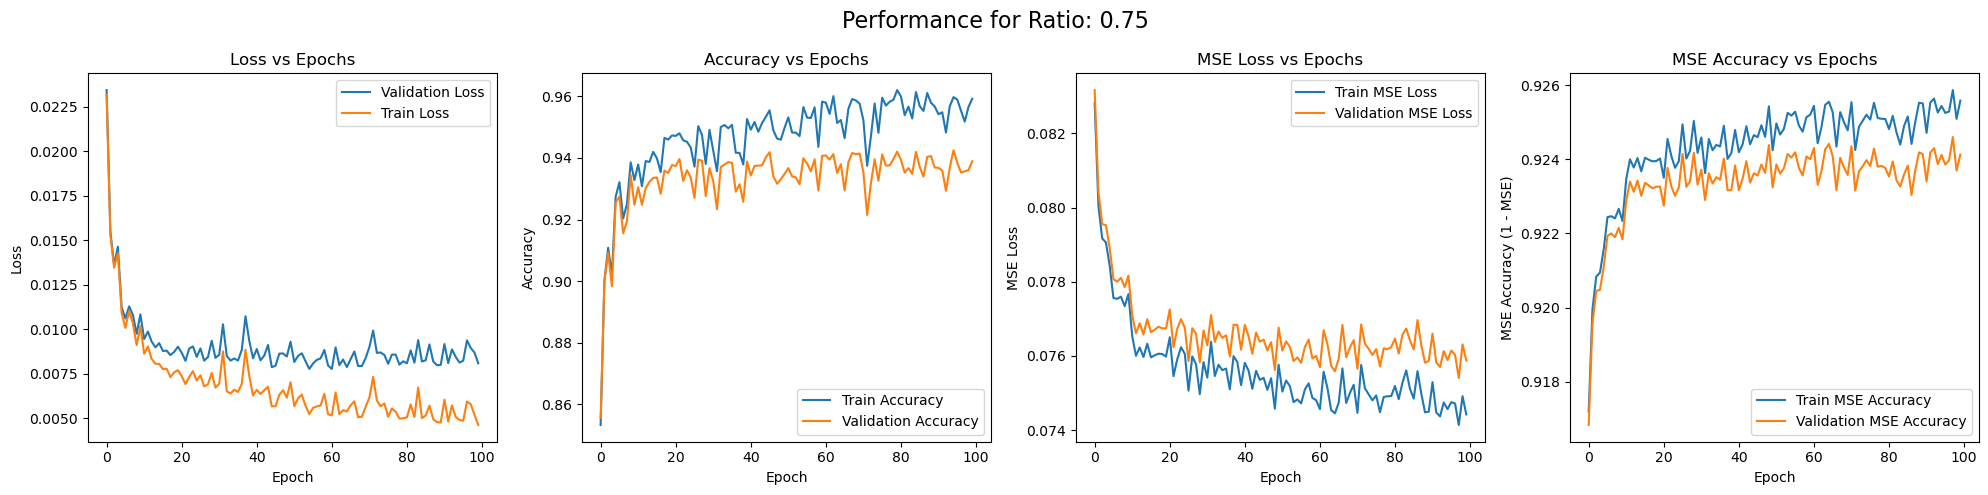

=== Ratio 0.75 ===
Test Accuracy:  0.9407070707070707
Test MSE Loss:  0.0757955029381044
Test MSE Accuracy:  0.9242044970618956
Test Loss:  0.008468692649550962


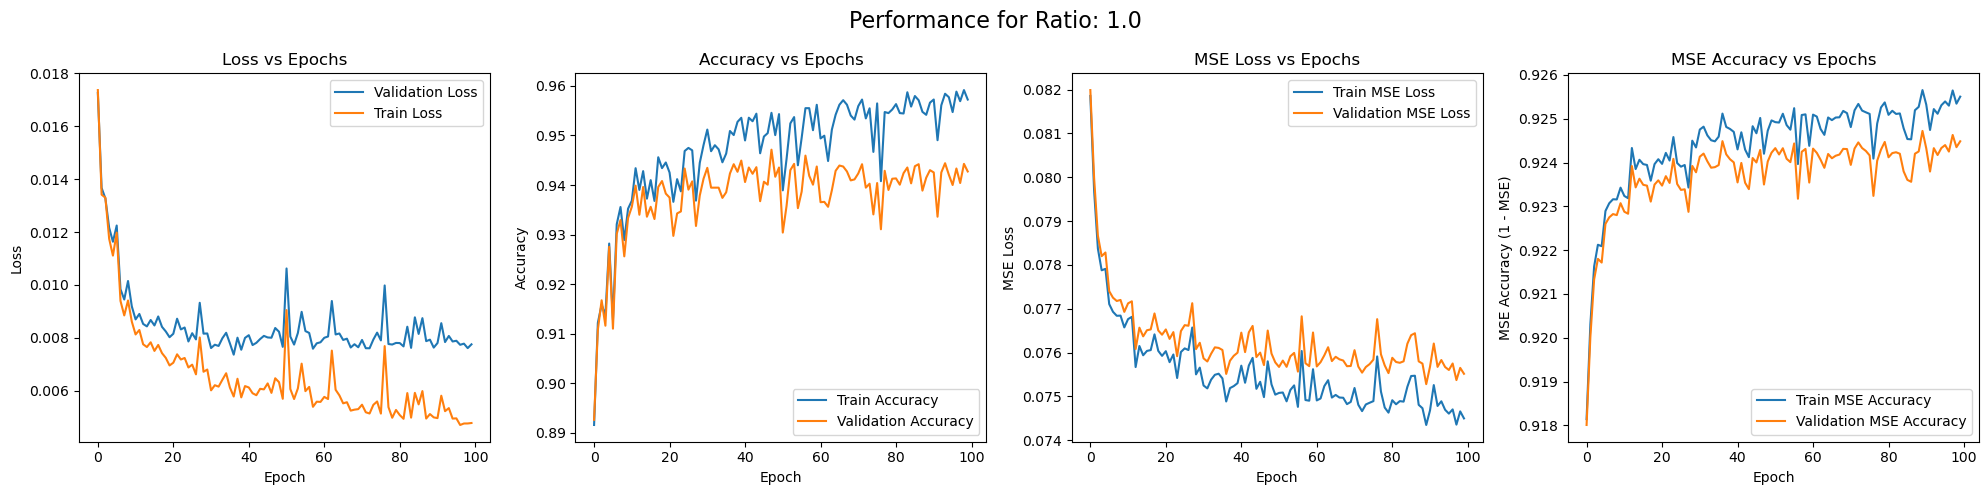

=== Ratio 1.0 ===
Test Accuracy:  0.942929292929293
Test MSE Loss:  0.07561668076298454
Test MSE Accuracy:  0.9243833192370154
Test Loss:  0.007991291568473433


In [7]:
label_map = {
    0: 'No Dot',
    0.5: 'Left Dot',
    1: 'Central Dot',
    1.5: 'Right Dot',
    2: 'Double Dot'
}

num_points = 150000
batch_size = 150

data_file_train = "Data\\Training\\Simulated_Train_Data\\Simulated_Train_Data"
data_file_test = "Data\\Testing\\Simulated_Test_Data"

train_dataset = DNN_Data(data_file_train, label_map, num_points=num_points, norm_method="zscore")
test_dataset = DNN_Data(data_file_test, label_map, num_points=num_points, norm_method="zscore")

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


dataset_size = len(train_dataset)
all_indices = np.arange(dataset_size)
np.random.seed(42)
np.random.shuffle(all_indices)
ratios = [0.25, 0.5, 0.75, 1.0]
results = {}

for ratio in ratios:
    subset_size = int(ratio * dataset_size)
    subset_indices = all_indices[:subset_size]
    train_size = int(0.9 * subset_size)
    train_indices = subset_indices[:train_size]
    val_indices = subset_indices[train_size:]

    train_split = Subset(train_dataset, train_indices)
    val_split = Subset(train_dataset, val_indices)

    train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False)
    num_epochs = 100

    model = DNNModel(input_dim=900, output_dim=5).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    performance_log = {
        'train_accuracy': [],
        'train_mse_accuracy': [],
        'val_accuracy': [],
        'val_mse_accuracy': [],
        'test_accuracy': [],
        'test_mse_accuracy': [],
        'train_loss': [],
        'val_loss': [],
        'test_loss': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_train_loss = 0.0
        print(f"Done with epoch {epoch}")

        for batch_inputs, batch_targets in train_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            optimizer.zero_grad()
            predictions = model(batch_inputs)
            loss = criterion(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_loss, train_acc, train_mse_acc = evaluate(model, train_loader, criterion)
        performance_log['train_loss'].append(train_loss)
        performance_log['train_accuracy'].append(train_acc)
        performance_log['train_mse_accuracy'].append(train_mse_acc)

        val_loss, val_acc, val_mse_acc = evaluate(model, val_loader, criterion)
        performance_log['val_loss'].append(val_loss)
        performance_log['val_accuracy'].append(val_acc)
        performance_log['val_mse_accuracy'].append(val_mse_acc)

    test_loss, test_acc, test_mse_acc = evaluate(model, test_dataloader, criterion)
    performance_log['test_loss'].append(test_loss)
    performance_log['test_accuracy'].append(test_acc)
    performance_log['test_mse_accuracy'].append(test_mse_acc)

    torch.save(model.state_dict(), f"DNN_model_ratio_{ratio}_epoch_{num_epochs}.pth")

    max_length = max(len(v) for v in performance_log.values())
    for key in performance_log:
        if len(performance_log[key]) < max_length:
            performance_log[key] += [np.nan] * (max_length - len(performance_log[key]))

    metrics_df = pd.DataFrame(performance_log)
    metrics_df.to_csv(f"DNN_metrics_ratio_{ratio}_epoch_{num_epochs}.csv", index=False)


    results[ratio] = performance_log

    print("Training is done")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test MSE Accuracy: {test_mse_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

for ratio in results:
    performance_log = results[ratio]

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Performance for Ratio: {ratio}', fontsize=16)

    # Loss plot
    ax[0].plot(performance_log['val_loss'], label="Validation Loss")
    ax[0].plot(performance_log['train_loss'], label="Train Loss")
    ax[0].set_title("Loss vs Epochs")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    # Accuracy plot
    ax[1].plot(performance_log['train_accuracy'], label="Train Accuracy")
    ax[1].plot(performance_log['val_accuracy'], label="Validation Accuracy")
    ax[1].set_title("Accuracy vs Epochs")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    # MSE Loss plot
    ax[2].plot(performance_log['train_mse_accuracy'], label="Train MSE Loss")
    ax[2].plot(performance_log['val_mse_accuracy'], label="Validation MSE Loss")
    ax[2].set_title("MSE Loss vs Epochs")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("MSE Loss")
    ax[2].legend()

    # MSE Accuracy plot
    train_mse_acc = [1 - v for v in performance_log['train_mse_accuracy']]
    val_mse_acc = [1 - v for v in performance_log['val_mse_accuracy']]
    ax[3].plot(train_mse_acc, label="Train MSE Accuracy")
    ax[3].plot(val_mse_acc, label="Validation MSE Accuracy")
    ax[3].set_title("MSE Accuracy vs Epochs")
    ax[3].set_xlabel("Epoch")
    ax[3].set_ylabel("MSE Accuracy (1 - MSE)")
    ax[3].legend()

    plt.tight_layout()
    plt.show()

    print(f"=== Ratio {ratio} ===")
    print("Test Accuracy: ", performance_log['test_accuracy'][0])
    print("Test MSE Loss: ", performance_log['test_mse_accuracy'][0])
    print("Test MSE Accuracy: ", 1 - performance_log['test_mse_accuracy'][0])
    print("Test Loss: ", performance_log['test_loss'][0])


### UNIT

Epoch 1/100
Done with epoch 0
Epoch 2/100
Done with epoch 1
Epoch 3/100
Done with epoch 2
Epoch 4/100
Done with epoch 3
Epoch 5/100
Done with epoch 4
Epoch 6/100
Done with epoch 5
Epoch 7/100
Done with epoch 6
Epoch 8/100
Done with epoch 7
Epoch 9/100
Done with epoch 8
Epoch 10/100
Done with epoch 9
Epoch 11/100
Done with epoch 10
Epoch 12/100
Done with epoch 11
Epoch 13/100
Done with epoch 12
Epoch 14/100
Done with epoch 13
Epoch 15/100
Done with epoch 14
Epoch 16/100
Done with epoch 15
Epoch 17/100
Done with epoch 16
Epoch 18/100
Done with epoch 17
Epoch 19/100
Done with epoch 18
Epoch 20/100
Done with epoch 19
Epoch 21/100
Done with epoch 20
Epoch 22/100
Done with epoch 21
Epoch 23/100
Done with epoch 22
Epoch 24/100
Done with epoch 23
Epoch 25/100
Done with epoch 24
Epoch 26/100
Done with epoch 25
Epoch 27/100
Done with epoch 26
Epoch 28/100
Done with epoch 27
Epoch 29/100
Done with epoch 28
Epoch 30/100
Done with epoch 29
Epoch 31/100
Done with epoch 30
Epoch 32/100
Done with epoc

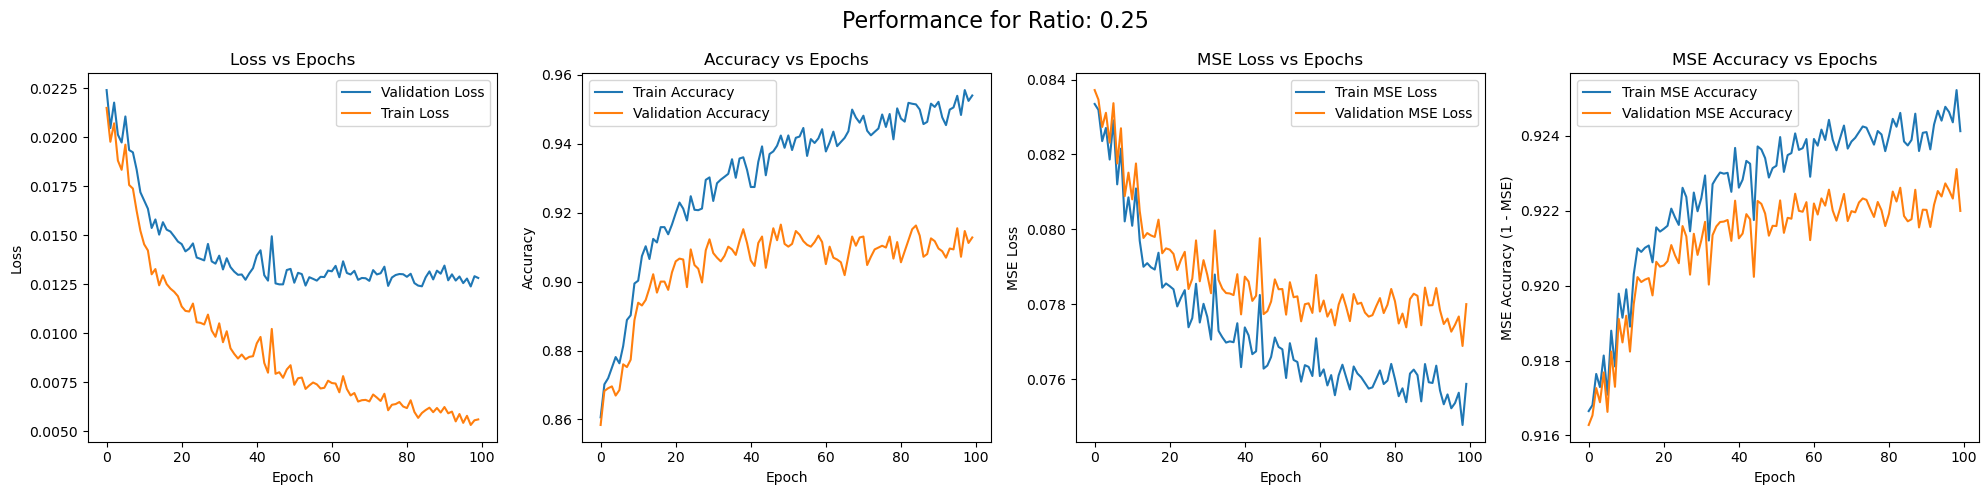

=== Ratio 0.25 ===
Test Accuracy:  0.916969696969697
Test MSE Loss:  0.07801589166576212
Test MSE Accuracy:  0.9219841083342379
Test Loss:  0.012143791145221754


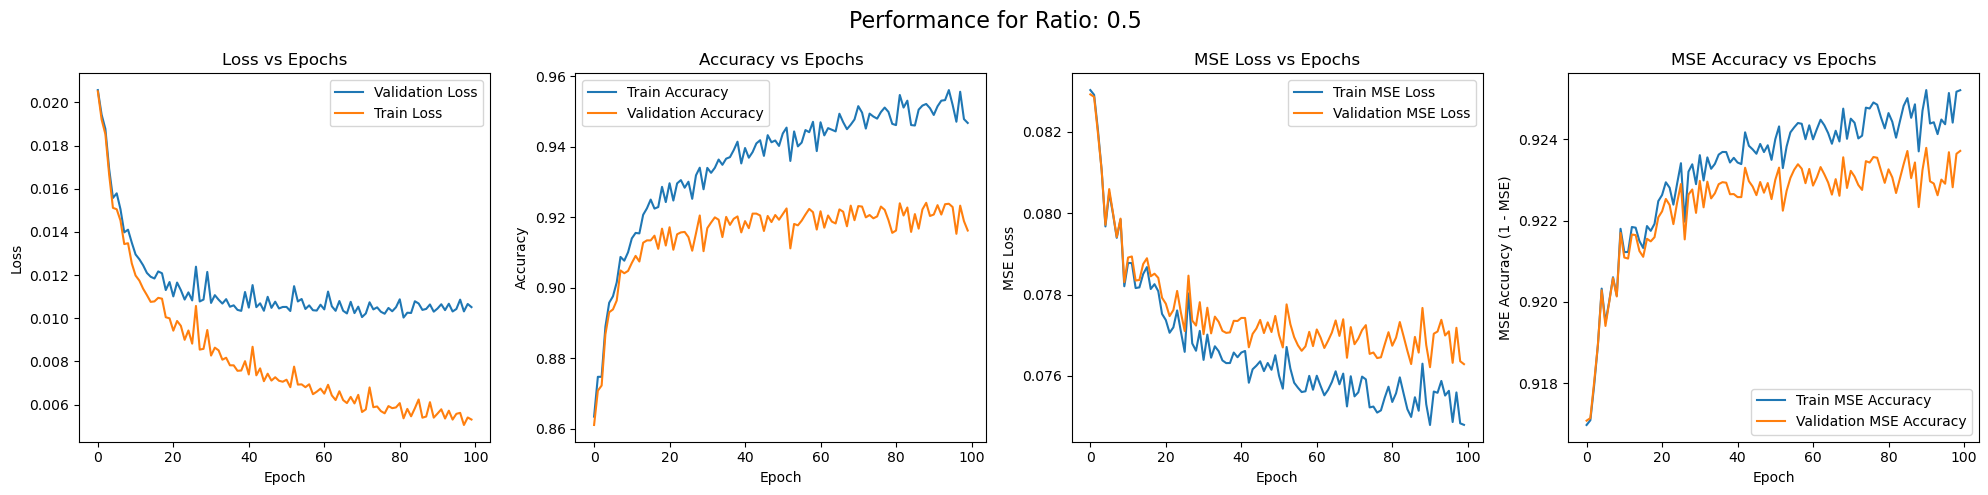

=== Ratio 0.5 ===
Test Accuracy:  0.9186868686868687
Test MSE Loss:  0.07674538298989787
Test MSE Accuracy:  0.9232546170101021
Test Loss:  0.011151122493725834


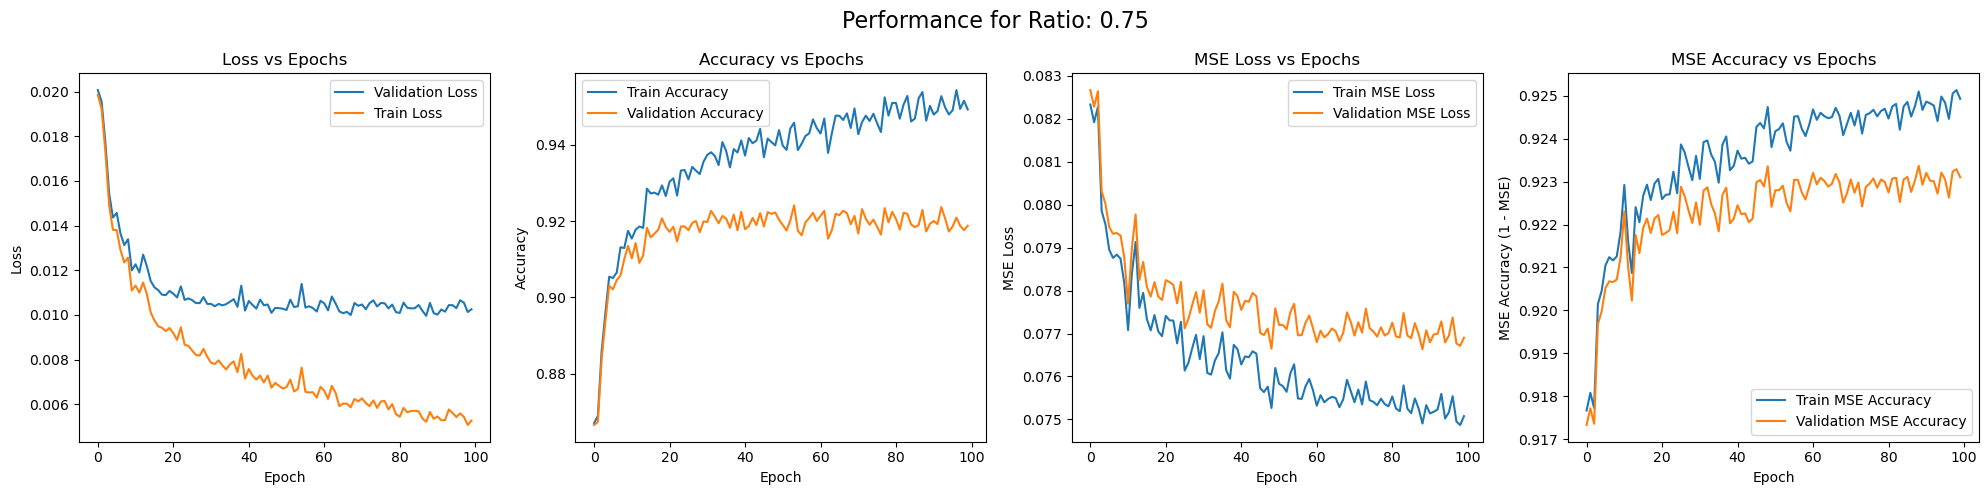

=== Ratio 0.75 ===
Test Accuracy:  0.9231313131313131
Test MSE Loss:  0.07690665791883614
Test MSE Accuracy:  0.9230933420811639
Test Loss:  0.010578917099558043


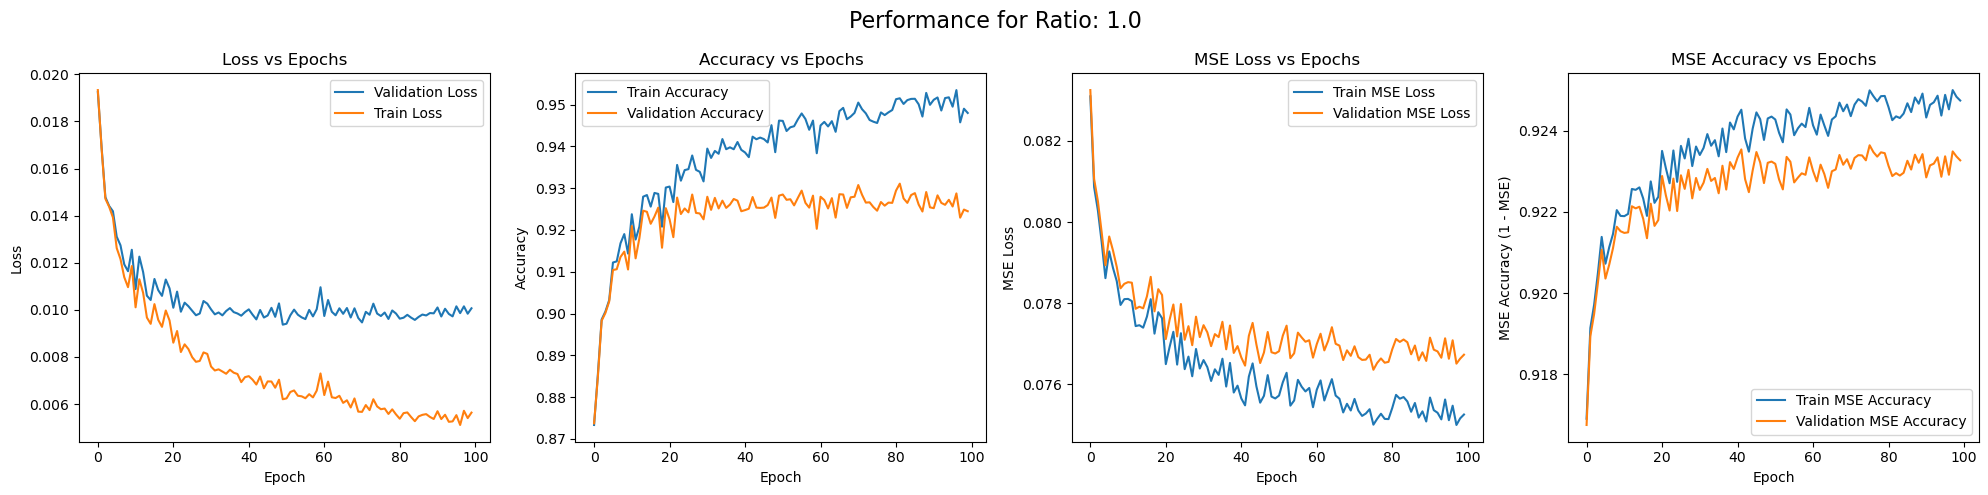

=== Ratio 1.0 ===
Test Accuracy:  0.9233333333333333
Test MSE Loss:  0.07680710235779936
Test MSE Accuracy:  0.9231928976422006
Test Loss:  0.010212221239326578


In [8]:
label_map = {
    0: 'No Dot',
    0.5: 'Left Dot',
    1: 'Central Dot',
    1.5: 'Right Dot',
    2: 'Double Dot'
}

num_points = 150000
batch_size = 150

data_file_train = "Data\\Training\\Simulated_Train_Data\\Simulated_Train_Data"
data_file_test = "Data\\Testing\\Simulated_Test_Data"

train_dataset = DNN_Data(data_file_train, label_map, num_points=num_points, norm_method="unit")
test_dataset = DNN_Data(data_file_test, label_map, num_points=num_points, norm_method="unit")

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


dataset_size = len(train_dataset)
all_indices = np.arange(dataset_size)
np.random.seed(42)
np.random.shuffle(all_indices)
ratios = [0.25, 0.5, 0.75, 1.0]
results = {}

for ratio in ratios:
    subset_size = int(ratio * dataset_size)
    subset_indices = all_indices[:subset_size]
    train_size = int(0.9 * subset_size)
    train_indices = subset_indices[:train_size]
    val_indices = subset_indices[train_size:]

    train_split = Subset(train_dataset, train_indices)
    val_split = Subset(train_dataset, val_indices)

    train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False)
    num_epochs = 100

    model = DNNModel(input_dim=900, output_dim=5).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    performance_log = {
        'train_accuracy': [],
        'train_mse_accuracy': [],
        'val_accuracy': [],
        'val_mse_accuracy': [],
        'test_accuracy': [],
        'test_mse_accuracy': [],
        'train_loss': [],
        'val_loss': [],
        'test_loss': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_train_loss = 0.0
        print(f"Done with epoch {epoch}")

        for batch_inputs, batch_targets in train_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            optimizer.zero_grad()
            predictions = model(batch_inputs)
            loss = criterion(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_loss, train_acc, train_mse_acc = evaluate(model, train_loader, criterion)
        performance_log['train_loss'].append(train_loss)
        performance_log['train_accuracy'].append(train_acc)
        performance_log['train_mse_accuracy'].append(train_mse_acc)

        val_loss, val_acc, val_mse_acc = evaluate(model, val_loader, criterion)
        performance_log['val_loss'].append(val_loss)
        performance_log['val_accuracy'].append(val_acc)
        performance_log['val_mse_accuracy'].append(val_mse_acc)

    test_loss, test_acc, test_mse_acc = evaluate(model, test_dataloader, criterion)
    performance_log['test_loss'].append(test_loss)
    performance_log['test_accuracy'].append(test_acc)
    performance_log['test_mse_accuracy'].append(test_mse_acc)

    torch.save(model.state_dict(), f"DNN_model_ratio_{ratio}_epoch_{num_epochs}.pth")

    max_length = max(len(v) for v in performance_log.values())
    for key in performance_log:
        if len(performance_log[key]) < max_length:
            performance_log[key] += [np.nan] * (max_length - len(performance_log[key]))

    metrics_df = pd.DataFrame(performance_log)
    metrics_df.to_csv(f"DNN_metrics_ratio_{ratio}_epoch_{num_epochs}.csv", index=False)


    results[ratio] = performance_log

    print("Training is done")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test MSE Accuracy: {test_mse_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

for ratio in results:
    performance_log = results[ratio]

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Performance for Ratio: {ratio}', fontsize=16)

    # Loss plot
    ax[0].plot(performance_log['val_loss'], label="Validation Loss")
    ax[0].plot(performance_log['train_loss'], label="Train Loss")
    ax[0].set_title("Loss vs Epochs")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    # Accuracy plot
    ax[1].plot(performance_log['train_accuracy'], label="Train Accuracy")
    ax[1].plot(performance_log['val_accuracy'], label="Validation Accuracy")
    ax[1].set_title("Accuracy vs Epochs")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    # MSE Loss plot
    ax[2].plot(performance_log['train_mse_accuracy'], label="Train MSE Loss")
    ax[2].plot(performance_log['val_mse_accuracy'], label="Validation MSE Loss")
    ax[2].set_title("MSE Loss vs Epochs")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("MSE Loss")
    ax[2].legend()

    # MSE Accuracy plot
    train_mse_acc = [1 - v for v in performance_log['train_mse_accuracy']]
    val_mse_acc = [1 - v for v in performance_log['val_mse_accuracy']]
    ax[3].plot(train_mse_acc, label="Train MSE Accuracy")
    ax[3].plot(val_mse_acc, label="Validation MSE Accuracy")
    ax[3].set_title("MSE Accuracy vs Epochs")
    ax[3].set_xlabel("Epoch")
    ax[3].set_ylabel("MSE Accuracy (1 - MSE)")
    ax[3].legend()

    plt.tight_layout()
    plt.show()

    print(f"=== Ratio {ratio} ===")
    print("Test Accuracy: ", performance_log['test_accuracy'][0])
    print("Test MSE Loss: ", performance_log['test_mse_accuracy'][0])
    print("Test MSE Accuracy: ", 1 - performance_log['test_mse_accuracy'][0])
    print("Test Loss: ", performance_log['test_loss'][0])
